<a href="https://colab.research.google.com/github/Ibrahim-Ayaz/E-scooter-Lane-Detection-Object-Detection-Project/blob/main/e_scooter_project_d7_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛴 E-Scooter Lane Deviation Detection (EfficientDet-D7)

In this notebook, we're going to do an end-to-end e-scooter lane object detection using TensorFlow. Our model of choice comes from the EfficientDet module class from TensorFlow's Hub library. The workflow will cover the following necessary steps:
  * Installing and setting up environmental dependencies/packages.
  * Initialising and uploading an e-scooter video sample to Google Drive.
  * Loading a pretrained object detection feature extractor from the EfficientDet-D7 module from TensorFlow Hub.
  * Creating a frames feature extraction function to prepare our pretrained feature extractor for inference.
  * Pass an e-scooter video sample to this feature extraction function to compute the lateral deviation from the road curb (d).
  * Plot the deviation results graphically using Python's plotting library, Matplotlib.

**PS:** For more information on the following tools we're going to use throughout this notebook project, refer to the following links:
  * TensorFlow: https://www.tensorflow.org/api_docs
  * TensorFlow Hub: https://www.tensorflow.org/hub
  * EfficientDet detector module class: https://tfhub.dev/tensorflow/efficientdet/d7/1
  * Matplotlib: https://matplotlib.org/stable/index.html

In [1]:
# 1️⃣ Install required packages
!pip install -q tensorflow==2.15.0 tensorflow-hub==0.16.1 tensorflow-addons==0.22.0 tensorflow-io==0.31.0 tensorflow-io-gcs-filesystem==0.31.0 pandas matplotlib tqdm imageio

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [2]:
# 2️⃣ Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')
out_dir = '/content/drive/MyDrive/e_scooter_output'
os.makedirs(out_dir, exist_ok=True)
print('Output directory:', out_dir)

Mounted at /content/drive
Output directory: /content/drive/MyDrive/e_scooter_output


In [3]:
# 3️⃣ Upload input video
from google.colab import files

uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print("🎞️ Uploaded:", video_path)

Saving 2nd video.mp4 to 2nd video.mp4
🎞️ Uploaded: 2nd video.mp4


In [4]:
# 4️⃣ Load EfficientDet-D7
import tensorflow as tf
import tensorflow_hub as hub

MODEL_URL = "https://tfhub.dev/tensorflow/efficientdet/d7/1"
detector = hub.load(MODEL_URL)
print("✅ EfficientDet-D7 loaded!")

✅ EfficientDet-D7 loaded!


In [5]:
# 5️⃣ Full-frame extraction using FFmpeg
import subprocess
import imageio.v3 as iio
import numpy as np
import tensorflow as tf
import glob

def extract_frames(path, max_frames=None):
    """Extract all frames using ffmpeg, return float32 tensor [N,H,W,3] in [0,1]."""
    tmp_dir = "/tmp/frames"
    subprocess.run(["rm", "-rf", tmp_dir])
    subprocess.run(["mkdir", "-p", tmp_dir])

    # Extract ALL frames (no fps change)
    subprocess.run(
        [
            "ffmpeg", "-i", path,
            "-qscale:v", "2",
            f"{tmp_dir}/frame_%06d.jpg"
        ],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        check=False,
    )

    imgs = sorted(glob.glob(f"{tmp_dir}/frame_*.jpg"))
    if not imgs:
        raise RuntimeError("No frames extracted. Check video format/path.")

    frames = np.stack([iio.imread(f) for f in imgs])

    if max_frames:
        frames = frames[:max_frames]

    frames = tf.convert_to_tensor(frames, dtype=tf.float32) / 255.0
    print(f"📸 Extracted {frames.shape[0]} frames (ALL FRAMES)")
    return frames

video = extract_frames(video_path)

📸 Extracted 674 frames (ALL FRAMES)


In [6]:
# 6️⃣ Updated Stage 6 — Full-length deviation mapping with interpolation
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import os

px_to_m = 0.004
distances = []
prev_value = None

detect_fn = detector.signatures["serving_default"]

print("🎞️ Processing frames (with interpolation support)...")

num_frames = video.shape[0]   # TRUE total number of frames

# Temporary storage for frame-by-frame deviation detection
raw_deviation = np.full(num_frames, np.nan)   # initialize all as missing

for i in tqdm(range(num_frames)):
    frame = video[i]  # float32 in [0,1]

    # Resize (float32)
    frame_resized = tf.image.resize(frame, (1536, 1536))

    # Convert to uint8 AFTER resizing
    frame_uint8 = tf.image.convert_image_dtype(frame_resized, tf.uint8)

    # Batch dimension
    input_tensor = tf.expand_dims(frame_uint8, 0)

    # Run EfficientDet-D7
    detections = detect_fn(input_tensor)
    boxes = detections["detection_boxes"][0].numpy()
    scores = detections["detection_scores"][0].numpy()

    # LOWER THRESHOLD to catch more frames
    if len(scores) > 0 and scores[0] > 0.10:
        ymin, xmin, ymax, xmax = boxes[0]
        center_x = (xmin + xmax) / 2.0
        frame_w = frame.shape[1]

        deviation_px = abs(center_x - 0.5) * frame_w
        deviation_m = deviation_px * px_to_m

        # Save raw deviation into its correct frame position
        raw_deviation[i] = deviation_m

# 🔧 INTERPOLATION STEP -------------------------------------------
# Replace missing detections with interpolated values
valid_idx = np.where(~np.isnan(raw_deviation))[0]
missing_idx = np.where(np.isnan(raw_deviation))[0]

if len(valid_idx) > 1:
    raw_deviation = np.interp(
        np.arange(num_frames),
        valid_idx,
        raw_deviation[valid_idx]
    )
else:
    print("⚠️ WARNING: Not enough valid detections to interpolate.")

# 🔧 REMOVE SMALL ERRORS + DUPLICATES ------------------------------
clean_distances = []
prev_value = None

for d in raw_deviation:
    if d > 0:
        if prev_value is None or abs(d - prev_value) > 1e-6:
            clean_distances.append(d)
            prev_value = d

# ------------------------------------------------------------------

csv_path = os.path.join(out_dir, "scooter_lane_distances.csv")
pd.DataFrame({"distance_m": clean_distances}).to_csv(csv_path, index=False)

print("💾 Saved clean, interpolated deviation CSV to:", csv_path)
print("Total deviation points (after interpolation):", len(clean_distances))
print("Interpolation ensured full video duration is preserved.")

🎞️ Processing frames (with interpolation support)...


100%|██████████| 674/674 [04:54<00:00,  2.28it/s]

💾 Saved clean, interpolated deviation CSV to: /content/drive/MyDrive/e_scooter_output/scooter_lane_distances.csv
Total deviation points (after interpolation): 674
Interpolation ensured full video duration is preserved.


🎞️ Detected FPS: 30.00
⏱️ Video duration plotted: 22.43 seconds


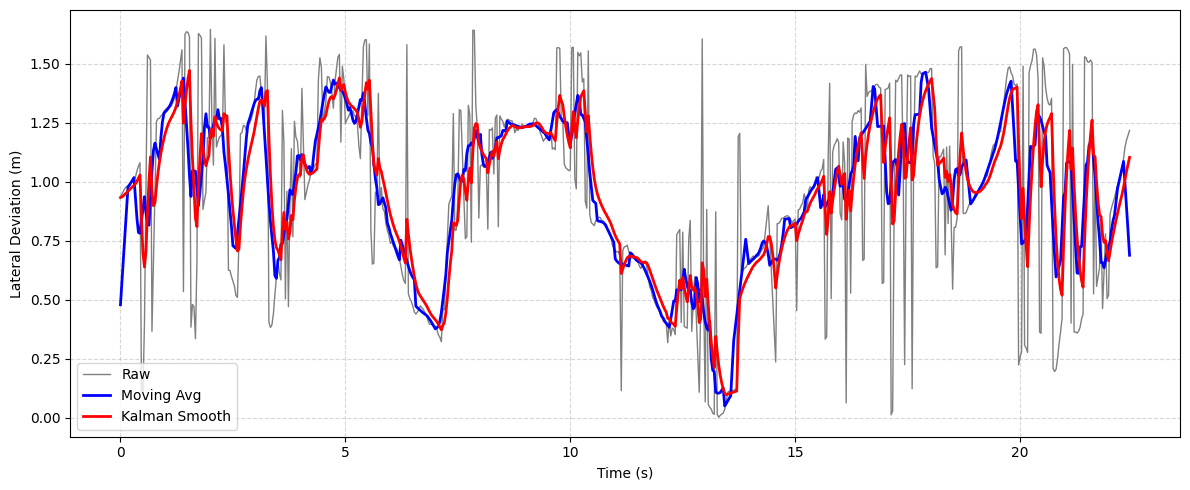

In [7]:
# 7️⃣ Plot deviation graph using auto-detected FPS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subprocess, json

def get_video_fps(path):
    """Return the real FPS using ffprobe."""
    cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-print_format", "json",
        "-show_entries", "stream=r_frame_rate",
        path,
    ]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    info = json.loads(result.stdout)
    rate = info["streams"][0]["r_frame_rate"]  # e.g. "30/1"
    num, den = rate.split("/")
    return float(num) / float(den)

data = pd.read_csv(csv_path)["distance_m"].dropna().to_numpy()
FPS = get_video_fps(video_path)

print(f"🎞️ Detected FPS: {FPS:.2f}")

if len(data) < 2:
    print("⚠️ Not enough deviation data to plot.")
else:
    t = np.arange(len(data)) / FPS
    print(f"⏱️ Video duration plotted: {t[-1]:.2f} seconds")

    # Moving average smoothing
    window = 10
    smooth = np.convolve(data, np.ones(window) / window, mode="same")

    # Kalman-like smoothing
    alpha = 0.2
    kalman = np.zeros_like(data)
    kalman[0] = data[0]
    for i in range(1, len(data)):
        kalman[i] = alpha * data[i] + (1 - alpha) * kalman[i - 1]

    plt.figure(figsize=(12, 5))
    plt.plot(t, data, color="gray", label="Raw", linewidth=1)
    plt.plot(t, smooth, color="blue", label="Moving Avg", linewidth=2)
    plt.plot(t, kalman, color="red", label="Kalman Smooth", linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Lateral Deviation (m)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()